#CityScope Spatial Urban Analysis

## Install Libraries

In order to use pandana package, need to upgrade numpy

In [3]:
!pip install --upgrade pip
!pip install --upgrade numpy

     |████████████████████████████████| 1.6MB 6.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 15.7 MB 103 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.21.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


^^ Restart the runtime if suggested

In [1]:
!pip install osmnet
!pip install pandana
!pip install cs-brix
!pip install folium
!pip install matplotlib==3.1.3

     |████████████████████████████████| 994 kB 8.0 MB/s 
     |████████████████████████████████| 6.6 MB 22.1 MB/s 
     |████████████████████████████████| 15.4 MB 34 kB/s 


In [ ]:
# CityScope Brix
import brix

# Data analysis
import geopandas as gpd
import pandas as pd
import numpy as np

# Visualisations
import folium
import matplotlib.pyplot as plt

# osm and pandana
import osmnet
import pandana

### Initialise the brix handler for our CityScope table and plot the GEOGRIDDATA

In [5]:
import pandas as pd
import pandana as pdna

Download the network data within our bounding from OSM

In [7]:
#min_lat = 10.751737
#min_lon = 106.683899
#max_lat = 10.771677
#max_lon = 106.723910
max_dist = 500 
max_poi = 3
min_lat = 10.753054
min_lon = 106.690159
max_lat = 10.762169
max_lon = 106.723167

In [8]:
nodes_df,edges_df=osmnet.load.network_from_bbox(lat_min=min_lat, lng_min=min_lon, lat_max=max_lat, 
                          lng_max=max_lon,  network_type='walk', 
                          )
nodes_df=nodes_df.rename(columns={'x': 'lon', 'y': 'lat'})

/usr/local/lib/python3.7/dist-packages/osmnet/load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](10.75305400,106.69015900,10.76216900,106.72316700);>;);out;'}"
Downloaded 893.9KB from www.overpass-api.de in 1.21 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 1.38 seconds
Returning OSM data with 5,499 nodes and 1,434 ways...
Edge node pairs completed. Took 2.00 seconds
Returning processed graph with 1,693 nodes and 2,230 edges...
Completed OSM data download and Pandana node and edge table creation in 3.92 seconds


In [9]:
network = pdna.Network(nodes_df['lon'], nodes_df['lat'], 
                          edges_df['from'], edges_df['to'], edges_df[['distance']])

In [10]:
from pandana.loaders import osm
restaurants = osm.node_query(min_lat, min_lon, max_lat, max_lon, tags='"amenity"="restaurant"')
restaurant_nodes = network.get_node_ids(restaurants.lon, restaurants.lat).values

# 1. Proximity

In [25]:
network.set_pois(category = 'restaurants',
                 maxdist = max_dist,
                 maxitems = max_poi,
                 x_col = restaurants.lon, 
                 y_col = restaurants.lat)
distances = network.nearest_pois(distance = max_dist,
                               category = 'restaurants',
                               num_pois = 1,
                               include_poi_ids = True)


In [29]:
print('Average Distance: ')
distances.describe()

Average Distance: 


,1,poi1
count,1693.000000,1.181000e+03
mean,302.446083,5.244721e+09
std,176.107785,1.107841e+09
min,0.000000,1.777244e+09
25%,133.537003,4.349787e+09
50%,311.757996,5.348828e+09
75%,500.000000,6.315688e+09
max,500.000000,7.239177e+09


In [34]:
proximity = 1/distances.values[:,0].sum()
print('Proximity: ', proximity)

Proximity:  1.9529677783534507e-06


# 2. Accessibility

In [37]:
network.set(restaurant_nodes, name = 'restaurants')
accessibility = network.aggregate(distance = max_dist,
                                  type = 'count',
                                  name = 'restaurants')
accessibility.describe()

count    1693.000000
mean        4.073833
std         4.364574
min         0.000000
25%         0.000000
50%         2.000000
75%         7.000000
max        15.000000
dtype: float64

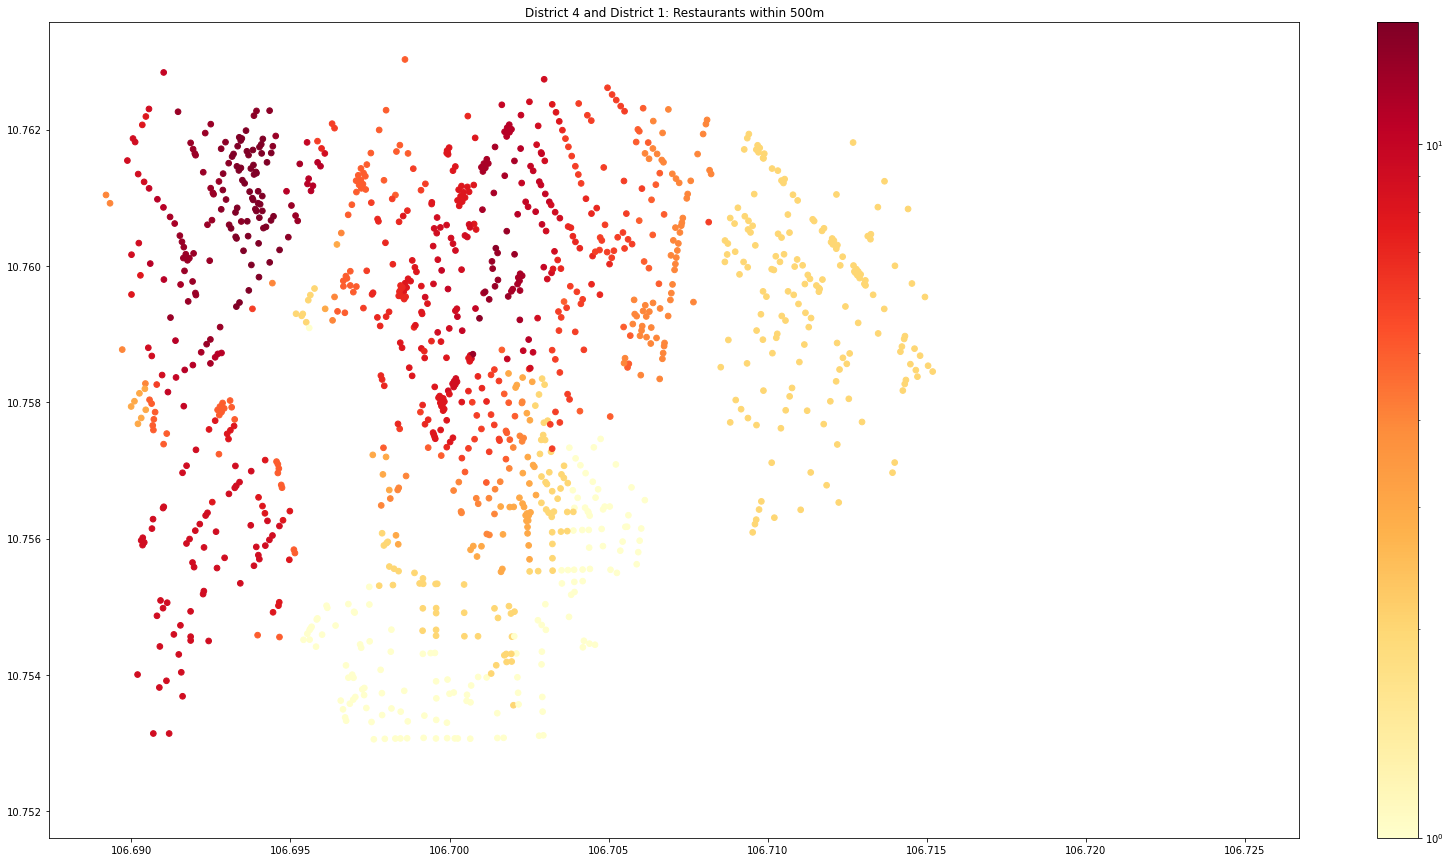

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(28,15))

plt.title('District 4 and District 1: Restaurants within 500m')
plt.scatter(network.nodes_df.x, network.nodes_df.y, 
            c=accessibility, s=32, cmap='YlOrRd', 
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()

plt.show()

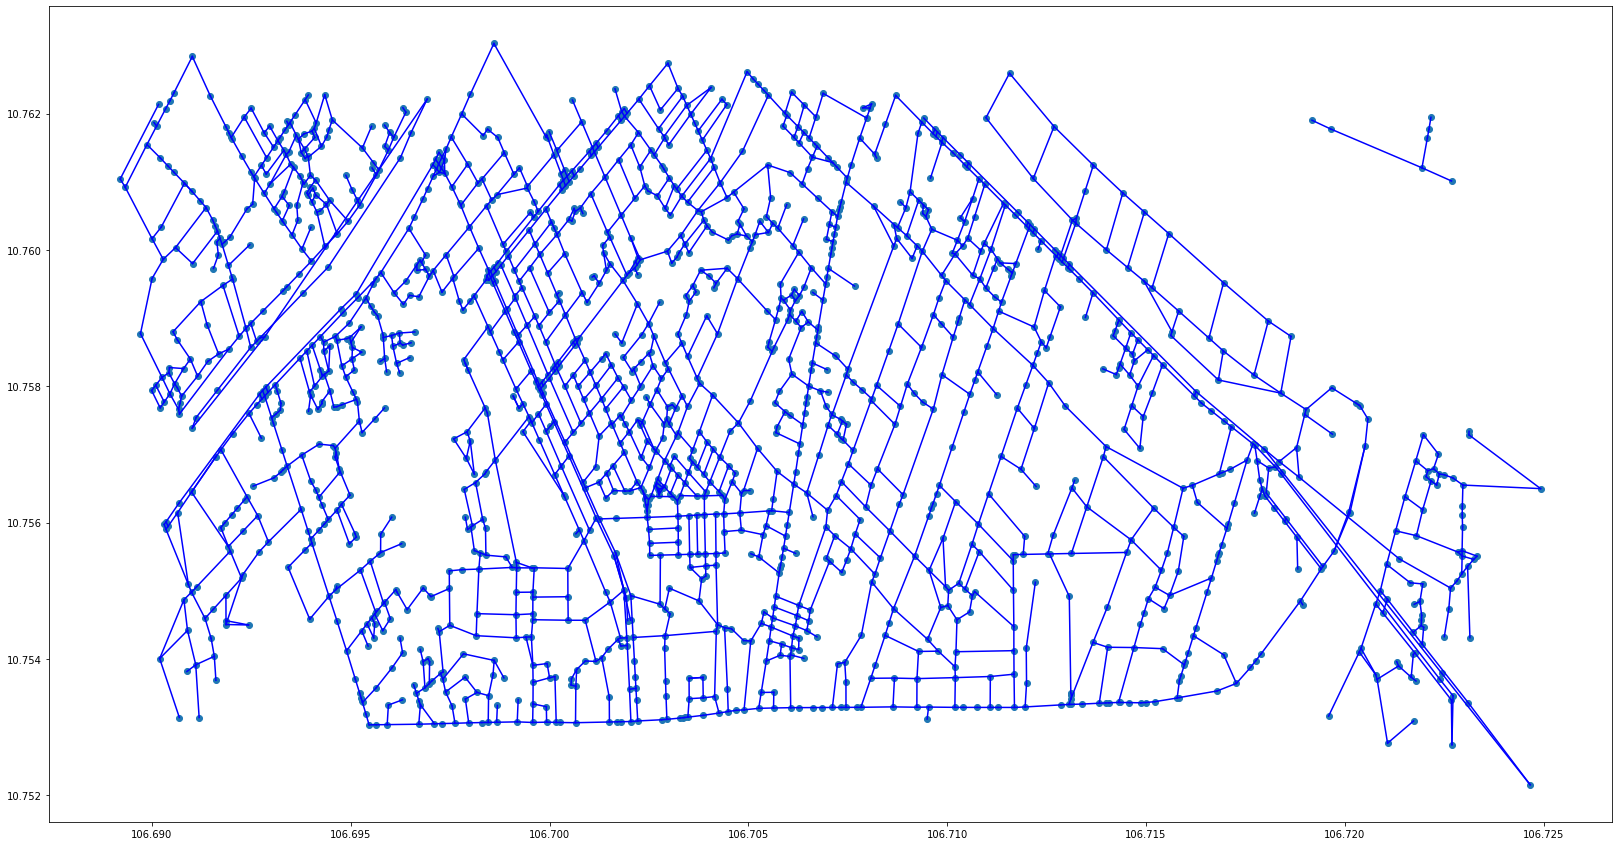

In [ ]:
plt.figure(figsize=(28,15))
plt.scatter(nodes_df['lon'], nodes_df['lat'])
for ind, row in edges_df.iterrows():
  from_lon=nodes_df.loc[row['from'], 'lon']
  from_lat=nodes_df.loc[row['from'], 'lat']
  to_lon=nodes_df.loc[row['to'], 'lon']
  to_lat=nodes_df.loc[row['to'], 'lat']
  plt.plot([from_lon, to_lon], [from_lat, to_lat], color='blue')
